In [1]:
#常用工具库
import re
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import time

#算法辅助 & 数据

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as skmet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix, recall_score,f1_score,accuracy_score,auc
#算法（单一学习器）
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.ensemble import AdaBoostClassifier , RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
#融合模型
from sklearn.ensemble import StackingClassifier

In [2]:
df = pd.read_csv("wrapper_63_2.csv")

In [3]:
# X提取变量特征；Y提取目标变量
X = df.drop('label', axis=1)
y = df['label']
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=100)

In [4]:
def fusion_estimators(clf):
    cv = KFold(n_splits=5,shuffle=True,random_state=100)
    results = cross_validate(clf,Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
    
    test = clf.fit(Xtrain,Ytrain).score(Xtest,Ytest)
    print("train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
         )

In [5]:
def individual_estimators(estimators):
    for estimator in estimators:
        cv = KFold(n_splits=5,shuffle=True,random_state=100)
        results = cross_validate(estimator[1],Xtrain,Ytrain
                             ,cv = cv
                             ,scoring = "accuracy"
                             ,n_jobs = -1
                             ,return_train_score = True
                             ,verbose=False)
        
        test = estimator[1].fit(Xtrain,Ytrain).score(Xtest,Ytest)
        print(estimator[0]
          ,"\n train_score:{}".format(results["train_score"].mean())
          ,"\n cv_mean:{}".format(results["test_score"].mean())
          ,"\n test_score:{}".format(test)
          ,"\n")

In [6]:
# 模型调参

In [7]:
SEED = 100
model_RF=RandomForestClassifier(class_weight="balanced", max_depth=7, max_leaf_nodes=60,
                       min_samples_split=3, n_estimators=130, random_state=420)
model_SVC = SVC(kernel='linear',class_weight="balanced",random_state = 420, probability=True)
model_GB = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_leaf=3,
                           n_estimators=70, random_state=420)
model_AB  = AdaBoostClassifier(learning_rate=0.2, n_estimators=20, random_state=420)
model_xgboost = xgb.XGBClassifier(eta=0.008,gamma=0.1,max_depth=4, n_estimators=60, max_delta_step=2,min_child_weight=9,random_state = 420)

In [8]:
estimators=[("RF",model_RF )
            , ("SVC", model_SVC)
              , ("GBT",model_GB),  ("AB",model_AB)
            ,("xgboost",model_xgboost)
            ]

In [9]:
final_estimator = RFC(n_estimators=160
                      , min_impurity_decrease=0.005
                      , random_state=420, n_jobs=8)
final_model = StackingClassifier(estimators=estimators
                         ,final_estimator=final_estimator
                         ,cv = 5       
                         ,stack_method = "auto"
                         ,n_jobs=8).fit(Xtrain,Ytrain)

In [10]:
# final_estimator = LogisticRegression(C = 1.1,multi_class='multinomial' ,random_state=420)
# final_model = StackingClassifier(estimators=estimators
#                          ,final_estimator=final_estimator
#                          ,cv = 5       
#                          ,stack_method = "auto"
#                          ,n_jobs=8).fit(Xtrain,Ytrain)

In [11]:
fusion_estimators(final_model)#(0.01)

train_score:0.9538690476190477 
 cv_mean:0.836904761904762 
 test_score:0.8583333333333333


In [9]:
fusion_estimators(final_model)#(0.1)

train_score:0.950297619047619 
 cv_mean:0.8285714285714286 
 test_score:0.8472222222222222


In [12]:
individual_estimators(estimators)

RF 
 train_score:0.9568452380952381 
 cv_mean:0.8345238095238094 
 test_score:0.85 

SVC 
 train_score:0.88125 
 cv_mean:0.8178571428571427 
 test_score:0.8361111111111111 

GBT 
 train_score:1.0 
 cv_mean:0.830952380952381 
 test_score:0.8472222222222222 

AB 
 train_score:0.8476190476190476 
 cv_mean:0.8214285714285715 
 test_score:0.825 

xgboost 
 train_score:0.8827380952380952 
 cv_mean:0.8261904761904763 
 test_score:0.8305555555555556 



params = {
          'final_estimator__C':np.arange(0.1, 10, 0.5)
         }
         

In [10]:
params = {'final_estimator__n_estimators': np.arange(80, 140, 10)
          ,'final_estimator__min_impurity_decrease':[0.001,0.005,0.008,0.01,0.05,0.08]
         }

In [11]:
grid = GridSearchCV(estimator=final_model, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)


GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('RF',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              max_depth=7,
                                                                              max_leaf_nodes=60,
                                                                              min_samples_split=3,
                                                                              n_estimators=130,
                                                                              random_state=420)),
                                                      ('SVC',
                                                       SVC(class_weight='balanced',
                                                           kernel='linear',
                                                           probabi

In [12]:
print('最佳参数：', grid.best_params_)

最佳参数： {'final_estimator__min_impurity_decrease': 0.05, 'final_estimator__n_estimators': 80}


In [13]:
fusion_estimators(final_model)

train_score:0.9744047619047619 
 cv_mean:0.8869047619047619 
 test_score:0.9111111111111111


In [13]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
models =  [model_RF,model_SVC, model_GB, model_AB,model_xgboost,final_model]
names =['RF','SVC','GBT','AB','xgboost','Stacking' ]

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


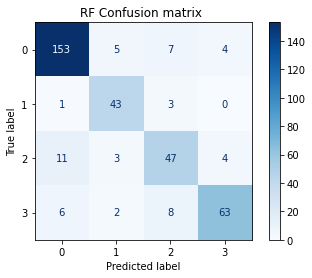

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


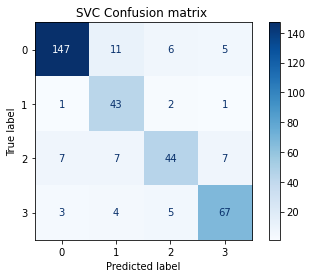

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


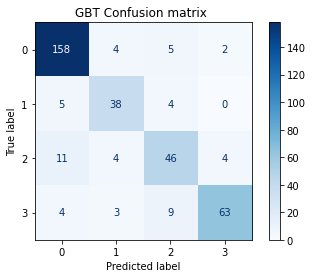

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


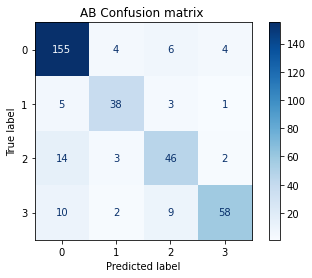

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


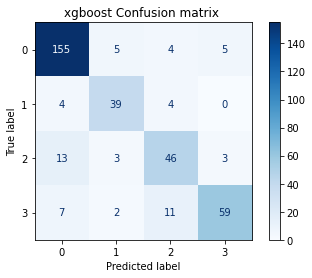

E:\Anaconda1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


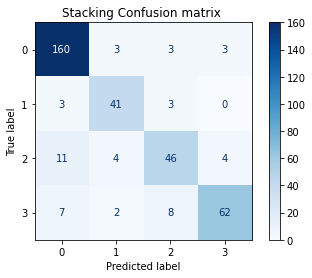

In [14]:
for (name, model) in zip(names, models):
    matrix = plot_confusion_matrix(model, Xtest, Ytest,
                                 cmap=plt.cm.Blues,
#                                  include_values = 'true' 
#                                  normalize='true'
                                  )
    
    plt.title('{} Confusion matrix '.format(name))
    plt.savefig('{} Confusion matrix '.format(name),dpi=1000,bbox_inches = 'tight')
    plt.show(matrix)
    plt.show()


labels =[0,1,2,3]
for (name, model) in zip(names, models):
    pred_enn = model.predict(Xtest)
    skmet.confusion_matrix(Ytest,pred_enn)
    print(name)
    print(skmet.classification_report(Ytest,pred_enn))
    matrix_enn = confusion_matrix(Ytest, pred_enn)
    print(matrix_enn)
    recall = recall_score(Ytest, pred_enn,labels=labels, average="macro")
    print('recall:',recall)
    acc = accuracy_score(Ytest, pred_enn)
    print('accuracy:',acc)
    f1 = f1_score(Ytest, pred_enn, average="macro")
    print("f1_score:",f1)

In [15]:
import numpy as np
import sklearn.metrics as skmet

def specificity_score(y_true, y_pred, target_class):
    cm = skmet.confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    
    # True negatives (TN) for the target class
    tn = sum(cm[i, j] for i in range(num_classes) for j in range(num_classes) if i != target_class and j != target_class)
    
    # False positives (FP) for the target class
    fp = sum(cm[i, target_class] for i in range(num_classes) if i != target_class)
    
    # Specificity for the target class
    specificity = tn / (tn + fp)
    return specificity

labels = [0, 1, 2, 3]

for (name, model) in zip(names, models):
    pred_enn = model.predict(Xtest)
    matrix_enn = skmet.confusion_matrix(Ytest, pred_enn)
    print(name)
    print(skmet.classification_report(Ytest, pred_enn))
    print(matrix_enn)
    recall = skmet.recall_score(Ytest, pred_enn, labels=labels, average="macro")
    print('recall:', recall)
    acc = skmet.accuracy_score(Ytest, pred_enn)
    print('accuracy:', acc)
    f1 = skmet.f1_score(Ytest, pred_enn, average="macro")
    print("f1_score:", f1)
    
    # Calculate and print specificity for each class
    model_specificity = []
    for target_class in labels:
        specificity = specificity_score(Ytest, pred_enn, target_class)
        model_specificity.append(specificity)
        print("Specificity for class {}: {:.3f}".format(target_class, specificity))

        
        # Calculate and print overall specificity (average specificity)
    overall_specificity = np.mean(model_specificity)
    print("Overall Specificity: {:.3f}".format(overall_specificity))
    
    # 计算每个类的准确率
    accuracy_per_class = {}
    for class_label in set(Ytest):
        class_indices = Ytest == class_label
        class_accuracy = accuracy_score(Ytest[class_indices],   pred_enn[class_indices])
        accuracy_per_class[class_label] = class_accuracy

    print("每个类的准确率：")
    for class_label, class_accuracy in accuracy_per_class.items():
        print(f"类别 {class_label}: {class_accuracy}")

RF
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       169
           1       0.81      0.91      0.86        47
           2       0.72      0.72      0.72        65
           3       0.89      0.80      0.84        79

    accuracy                           0.85       360
   macro avg       0.83      0.84      0.83       360
weighted avg       0.85      0.85      0.85       360

[[153   5   7   4]
 [  1  43   3   0]
 [ 11   3  47   4]
 [  6   2   8  63]]
recall: 0.8351910845788904
accuracy: 0.85
f1_score: 0.8307692307692307
Specificity for class 0: 0.906
Specificity for class 1: 0.968
Specificity for class 2: 0.939
Specificity for class 3: 0.972
Overall Specificity: 0.946
每个类的准确率：
类别 0: 0.9053254437869822
类别 1: 0.9148936170212766
类别 2: 0.7230769230769231
类别 3: 0.7974683544303798
SVC
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       169
           1       0.66      0.91      0.

In [16]:
from sklearn.metrics import confusion_matrix

def quadratic_weighted_kappa(actual, predicted, num_classes):
    """
    计算多分类的二次加权kappa
    
    参数：
        actual：实际的类别标签（1维数组）
        predicted：预测的类别标签（1维数组）
        num_classes：类别的数量（整数）
        
    返回值：
        quadratic_weighted_kappa：二次加权kappa的值
    """
    assert len(actual) == len(predicted), "actual and predicted arrays must have the same length"
    
    # 将类别标签减去1，使类别从0开始
    actual = np.array(actual) - 1
    predicted = np.array(predicted) - 1
    
    # 计算实际类别与预测类别之间的混淆矩阵
    conf_matrix = np.zeros((num_classes, num_classes))
    for a, p in zip(actual, predicted):
        conf_matrix[a][p] += 1
    
    # 计算样本数量
    total_samples = len(actual)
    
    # 计算类别的权重
    weights = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            weights[i][j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    
    # 计算实际类别分布
    actual_hist = np.zeros(num_classes)
    for a in actual:
        actual_hist[a] += 1
    
    # 计算预测类别分布
    predicted_hist = np.zeros(num_classes)
    for p in predicted:
        predicted_hist[p] += 1
    
    # 计算期望的混淆矩阵
    expected_matrix = np.outer(actual_hist, predicted_hist) / total_samples
    
    # 计算观察到的kappa值
    observed_kappa = (np.sum(weights * conf_matrix)) / total_samples
    
    # 计算期望的kappa值
    expected_kappa = (np.sum(weights * expected_matrix)) / total_samples
    
    # 计算二次加权kappa
    quadratic_weighted_kappa = 1 - (observed_kappa / expected_kappa)
    
    return quadratic_weighted_kappa

In [17]:
for (name, model) in zip(names, models):
    y_pred = model.predict(Xtest)
    kappa = quadratic_weighted_kappa(Ytest,y_pred,4)
    print(name)
    print(kappa)

RF
0.8137931034482759
SVC
0.76741885625966
GBT
0.7858251422659079
AB
0.7618368141133739
xgboost
0.7793548387096774
Stacking
0.8294333784567782


C:\Users\22394\AppData\Local\Temp\ipykernel_31764\1403566404.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


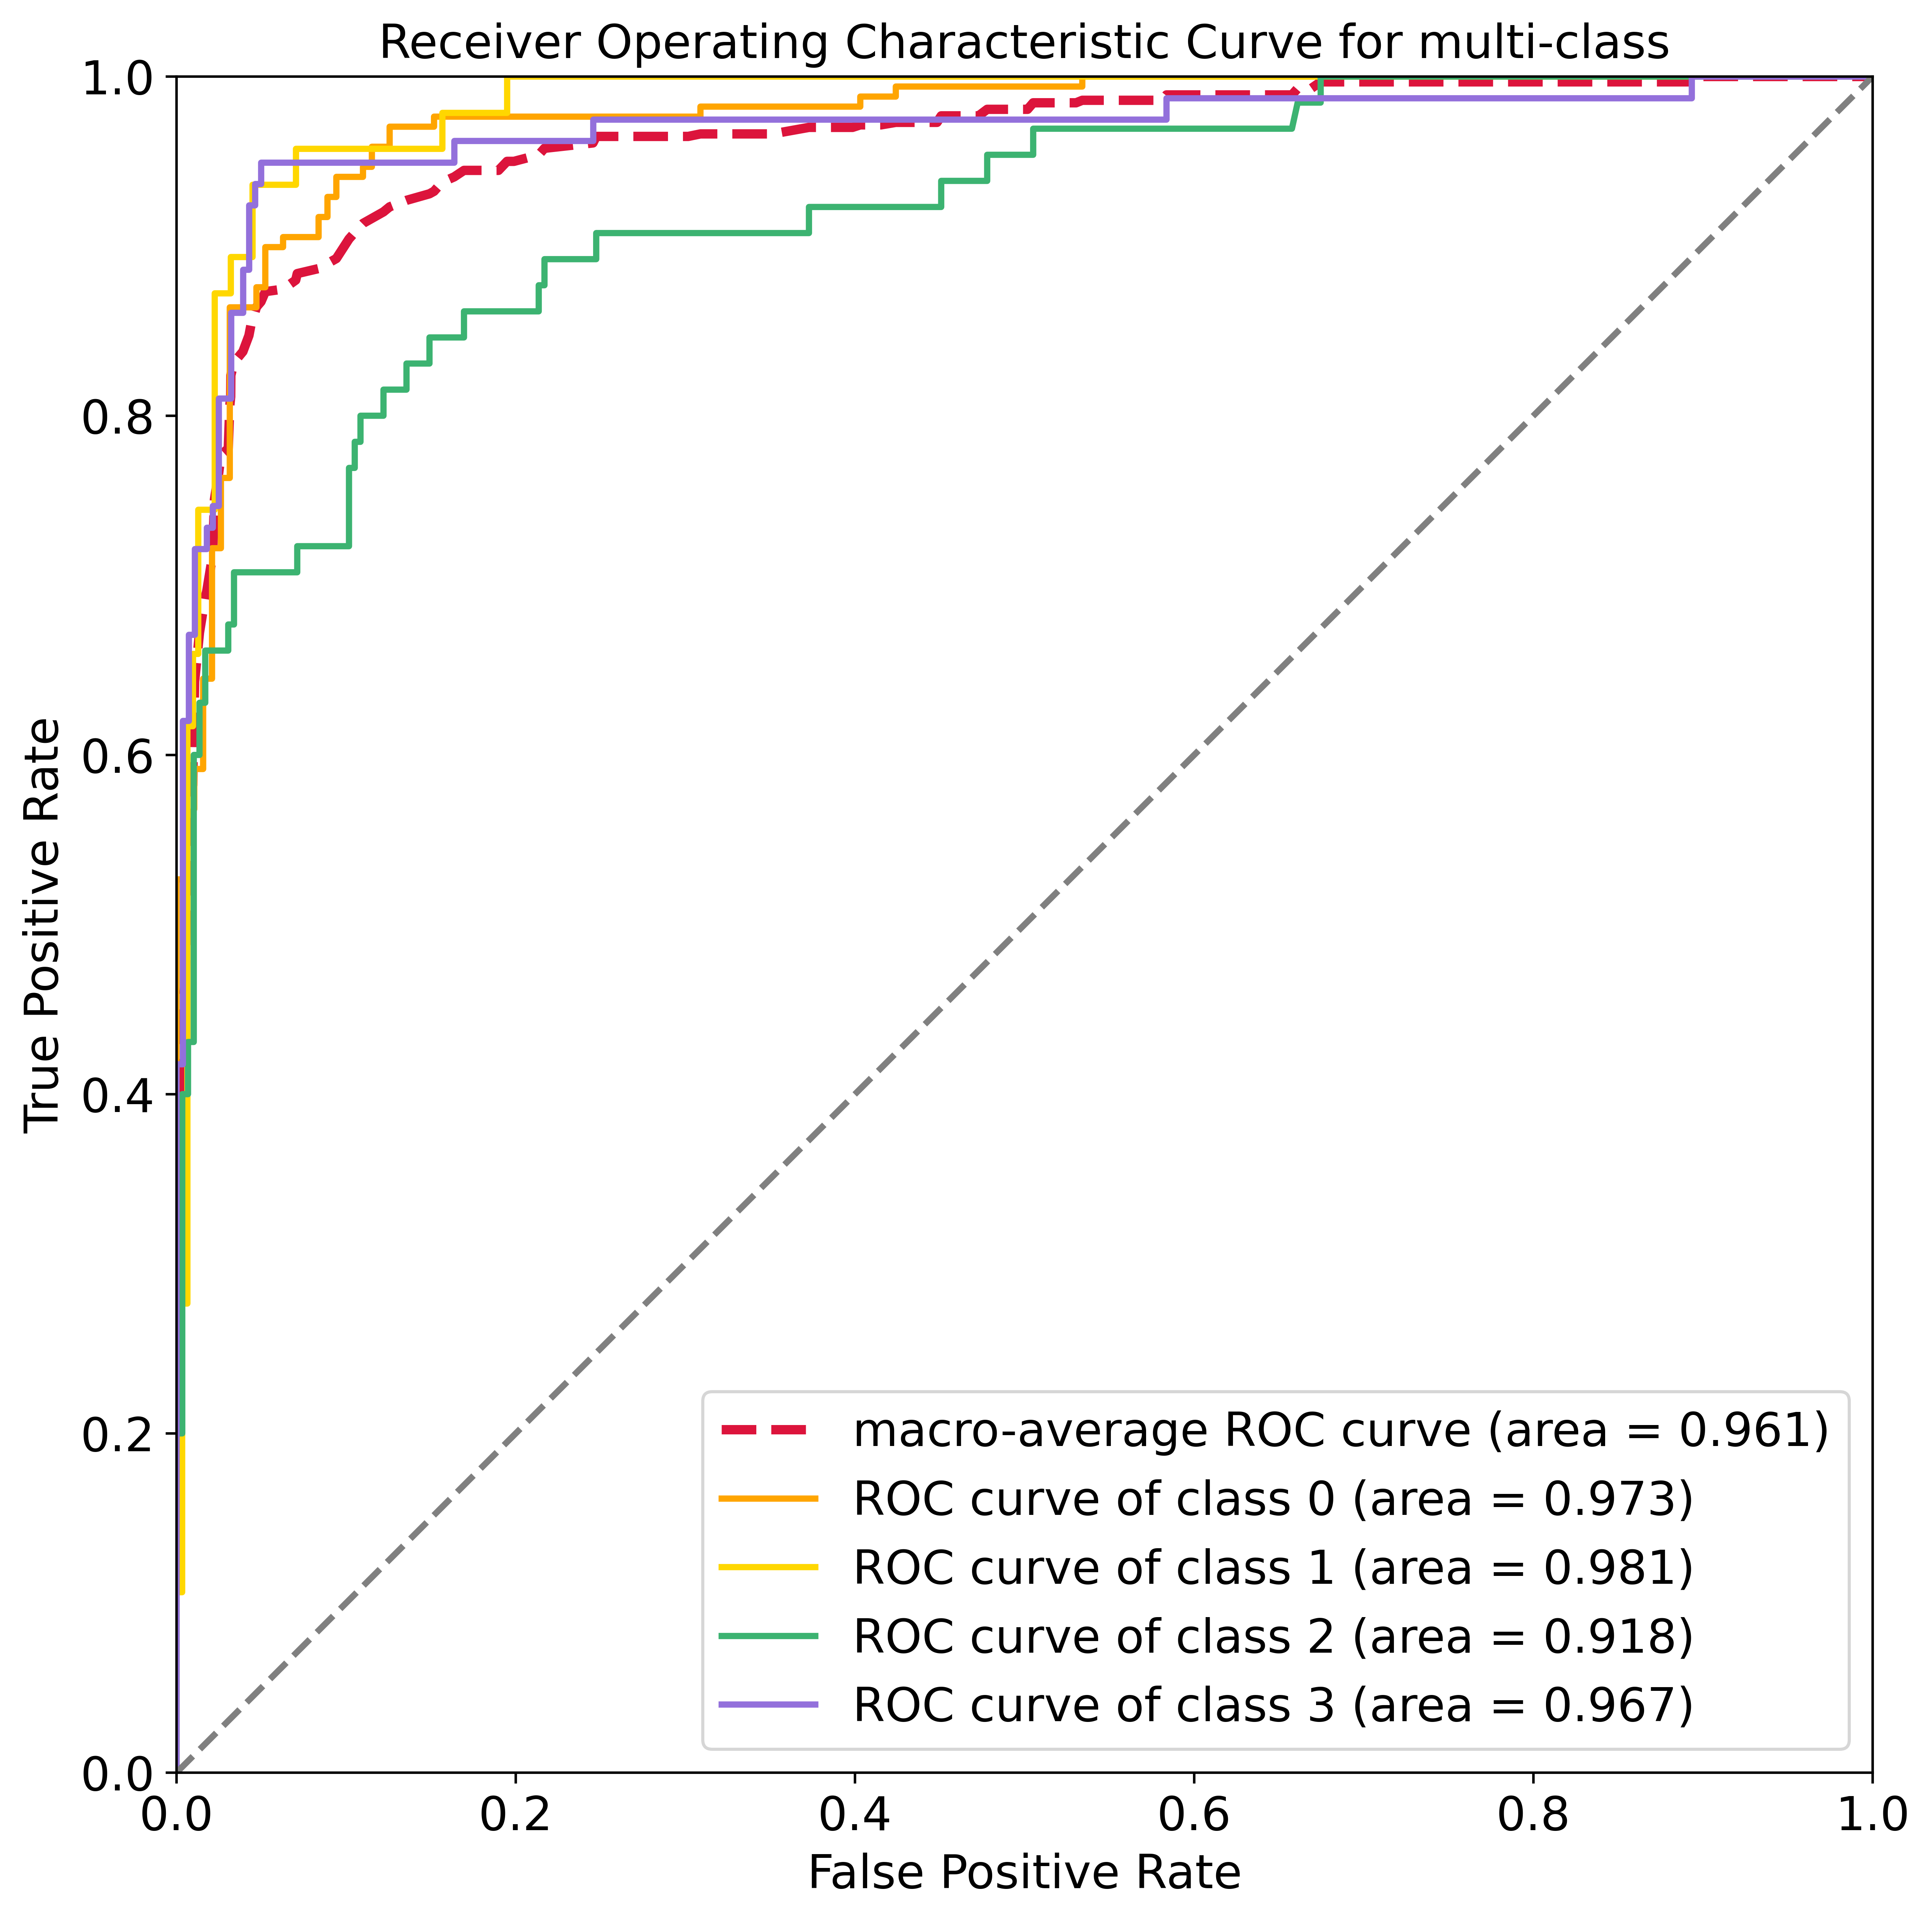

In [18]:
from scipy import interp
from sklearn.preprocessing import label_binarize

colors = [
          'orange',
          'gold',
          'mediumseagreen', 
          'mediumpurple'
        ]
y_score = final_model.predict_proba(Xtest) 
# 将标签二值化
y_test = label_binarize(Ytest, classes=[0, 1, 2,3]) # 三个类别
 # 设置种类
n_classes =y_test.shape[1]

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 10),dpi=600)    
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='crimson', linestyle='--', linewidth=3)    

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(labelsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic Curve for multi-class',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.savefig('ROC_mul.png', dpi=1000, bbox_inches='tight')
plt.show()



C:\Users\22394\AppData\Local\Temp\ipykernel_31764\1267525021.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_precision += interp(all_recall, recall[i][::-1], precision[i][::-1])


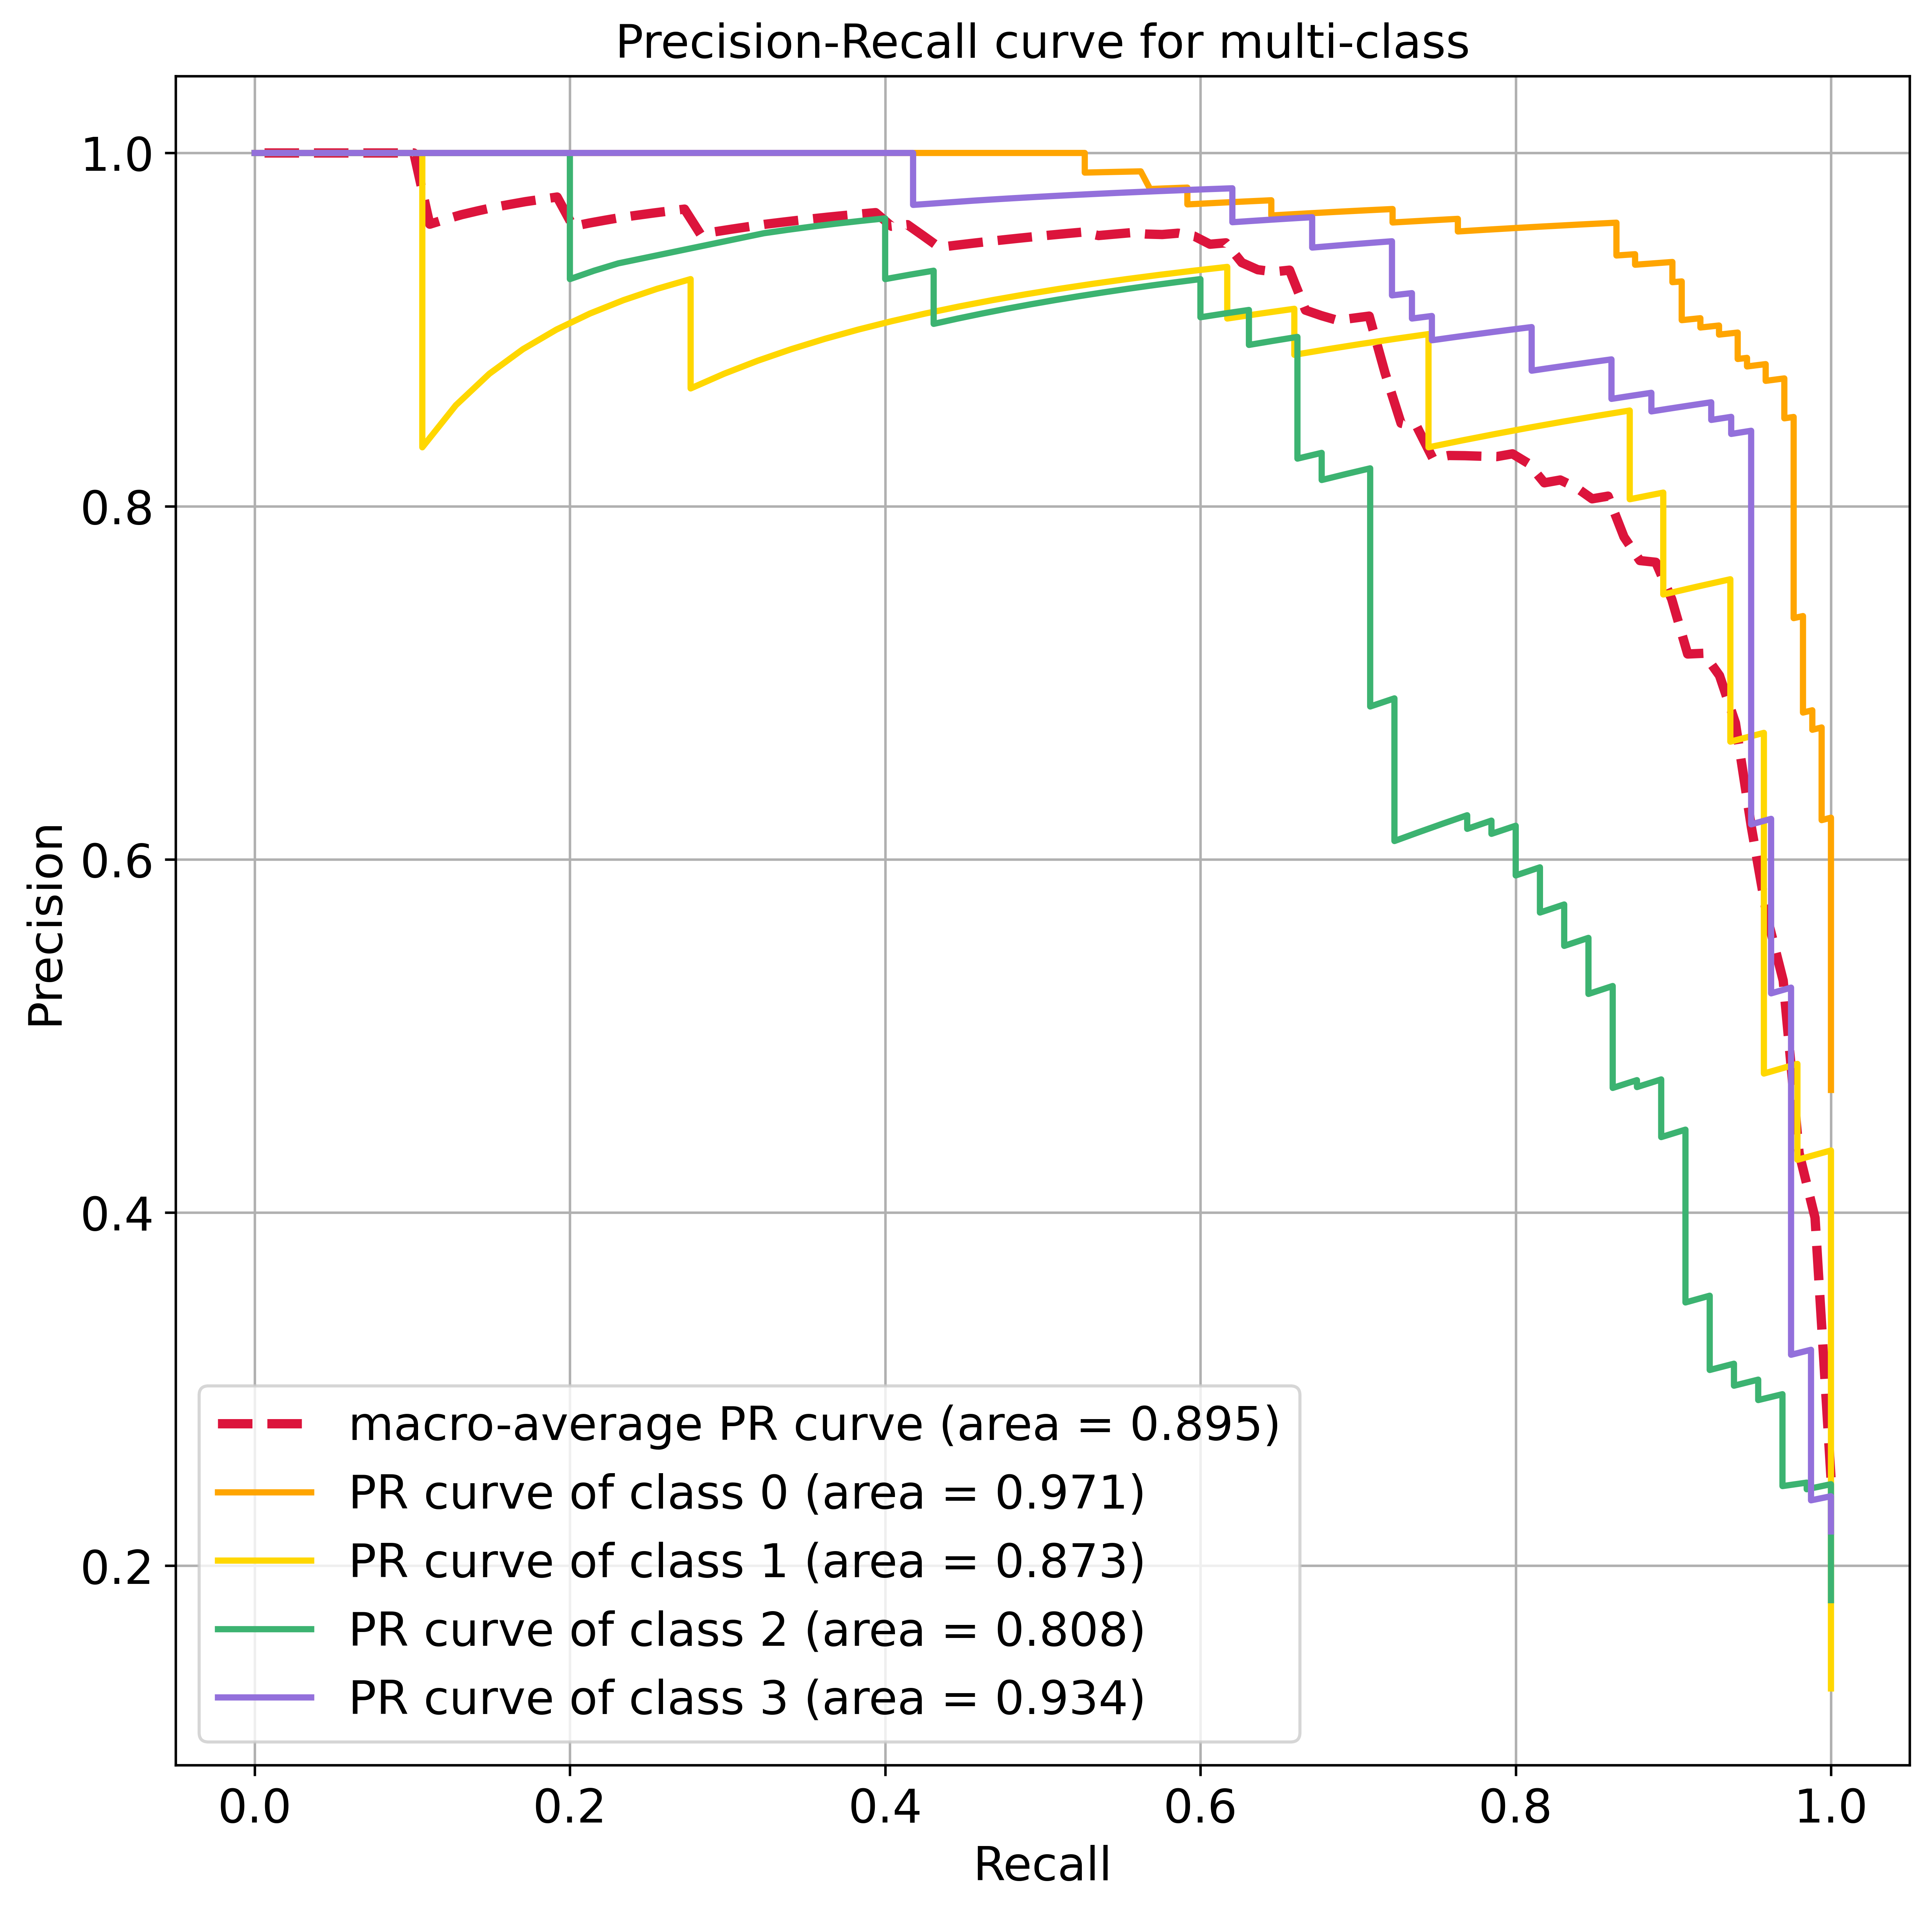

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

colors = ['orange', 'gold', 'mediumseagreen', 'mediumpurple']
y_score = final_model.predict_proba(Xtest)
y_test = label_binarize(Ytest, classes=[0, 1, 2, 3])  # Four classes
n_classes = y_test.shape[1]

precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Compute macro-average PR curve and PR AUC (method one)
all_recall = np.linspace(0, 1, 100)

mean_precision = np.zeros_like(all_recall)
for i in range(n_classes):
    mean_precision += interp(all_recall, recall[i][::-1], precision[i][::-1])

mean_precision /= n_classes
recall["macro"] = all_recall[::-1]
precision["macro"] = mean_precision[::-1]
pr_auc["macro"] = auc(recall["macro"], precision["macro"])

plt.figure(figsize=(10, 10), dpi=600)
plt.plot(recall["macro"], precision["macro"],
         label='macro-average PR curve (area = {0:0.3f})'
               ''.format(pr_auc["macro"]),
         color='crimson', linestyle='--', linewidth=3)

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.3f})'
                   ''.format(i, pr_auc[i]))
    

plt.tick_params(labelsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall curve for multi-class', fontsize=15)
plt.legend(loc="lower left", fontsize=15)
plt.grid(True)
plt.savefig('PR curve.png', dpi=1000, bbox_inches='tight')
plt.show()
